### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('image', cmap='Greys')
import rpy2 
%load_ext rpy2.ipython
%run pybase
%run heavysnow 

### Data 

In [36]:
f=np.array([-1,-1,-1,1,-1,-1,-1,1,1,1,-1,1,1,1])*1.0
n=len(f)
V=list(range(n))
W=np.zeros([n,n])
for i in range(n):
    for j in range(n):
        if abs(i-j)==1: W[i,j]=1
W[0,0]=0
W[n-1,n-1]=0

In [37]:
gs=GraphSignal(V,W,f)

In [38]:
gs.initdist=np.array([1/n]*n)

### HST

In [200]:
%run heavysnow 
hst=HeavySnowTransform(gs)
hst.snow(tau=1000000,b=0.001,maxflow=2)

HST (tau= 1000000, b=0.001)
1000000/1000000
HST completed and all history is recorded.


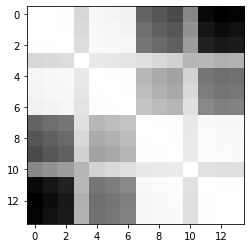

In [138]:
plt.imshow(hst.snowdistance)

In [173]:
hst.snowdistance/(hst.b**2*hst.tau)

array([[   0.     ,    6.62729,   21.09601,  513.21229,  144.99293,
         174.78548,  229.86424, 1367.48288, 1469.01427, 1541.47081,
        1104.37238, 1939.21254, 2003.70522, 1972.38438],
       [   6.62729,    0.     ,    8.70526,  478.68804,  114.41082,
         140.73199,  190.27027, 1290.38981, 1388.36882, 1458.73142,
        1027.58343, 1847.46733, 1911.12211, 1884.55171],
       [  21.09601,    8.70526,    0.     ,  450.58642,   88.31524,
         111.50557,  156.10131, 1223.00711, 1319.36988, 1388.02978,
         961.47749, 1769.22195, 1832.48321, 1808.77811],
       [ 513.21229,  478.68804,  450.58642,    0.     ,  327.31126,
         348.63769,  384.03813,  429.56457,  503.89864,  568.92602,
         801.50731,  780.10205,  830.37839,  815.65883],
       [ 144.99293,  114.41082,   88.31524,  327.31126,    0.     ,
          11.23731,   35.08409,  789.55023,  865.05526,  922.90664,
         549.19535, 1224.63325, 1280.31923, 1264.28261],
       [ 174.78548,  140.73199,  11

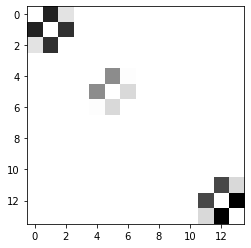

In [264]:
theta=10
hst.snowweight=np.exp(-hst.snowdistance/(theta*hst.tau*hst.b**2))-np.eye(n,n)
plt.imshow(hst.snowweight)

In [252]:
np.std(W), np.std(hst.snowweight)

(0.3391993905835645, 0.40491892481254094)

### 시각화를 위해서 R로 자료를 옮김

In [253]:
maxtau=hst.tau
W_Graph=hst.graphweight
W_Euclid=hst.euclidweight
W_HST=hst.snowweight
V=np.array(hst.V)
f=hst.f
n=hst.n
%R -i maxtau,W_Graph,W_Euclid,W_HST,V,f,n

### R을 활용한 시각화 (1): 원래자료 

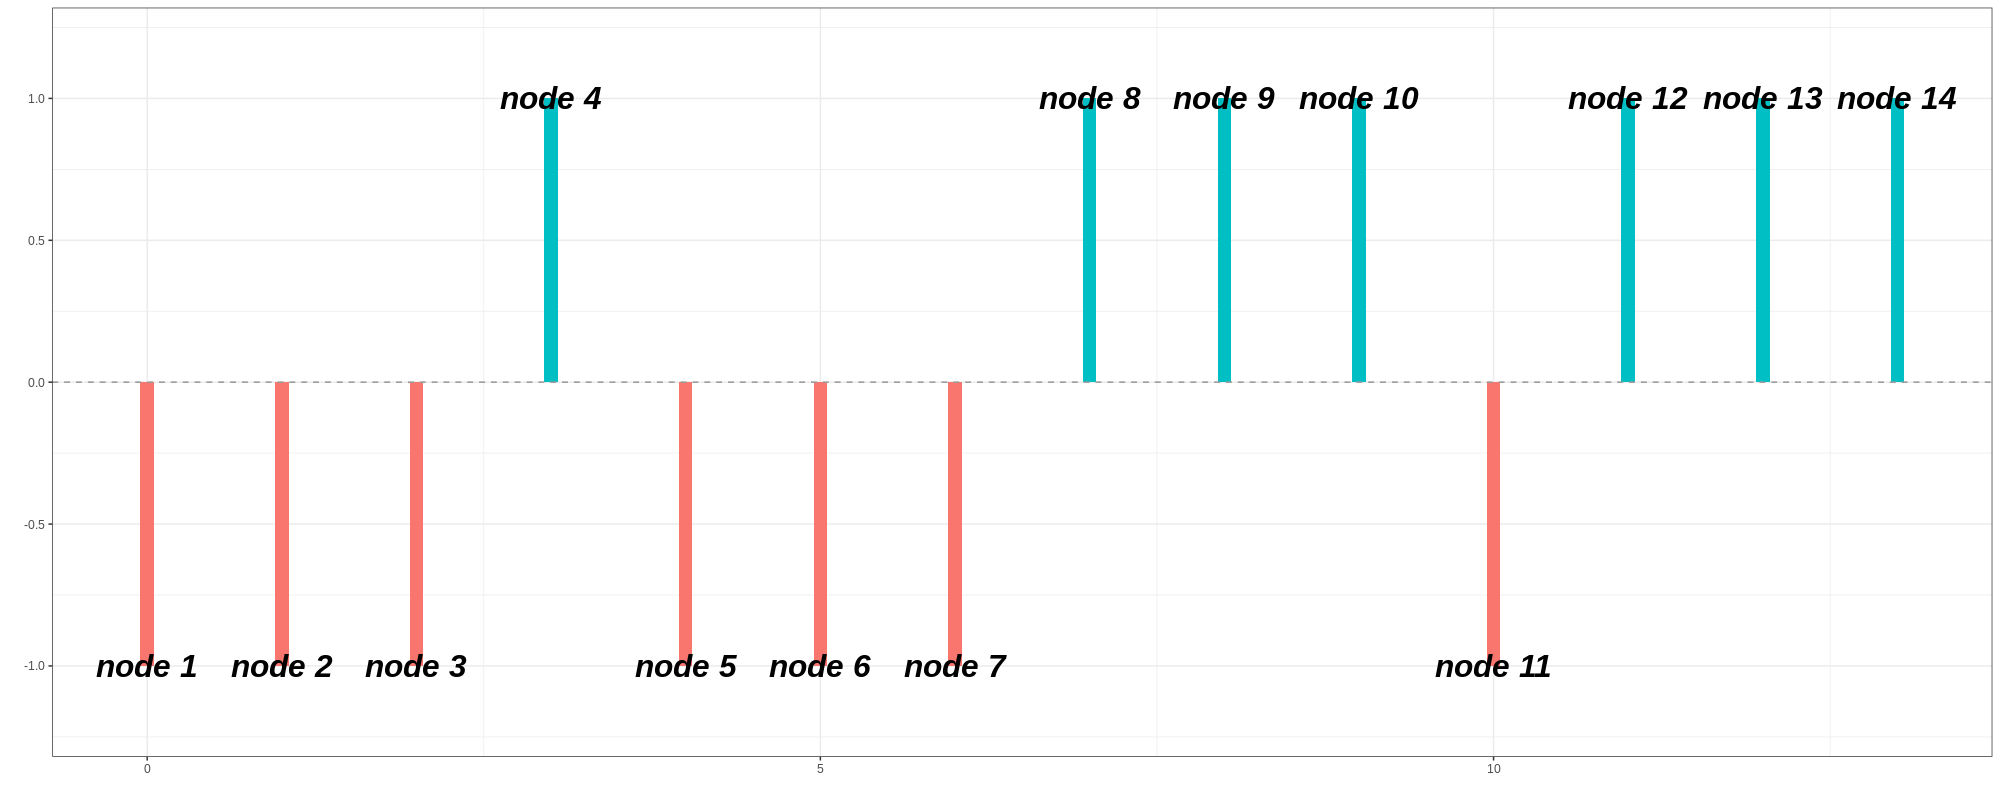

In [254]:
%%R -w 2000 -h 800 -r 100
library(tidyverse)
library(latex2exp)
library(gridExtra)
source('rbase.R')
Vtext=str_c('node ',V+1)
fig0<-ggplot(data=tibble(V=V,f=f,Vtext=Vtext),aes(x=V,y=f,label=Vtext))+
geom_col(aes(fill=(f>0)),width=0.1)+geom_hline(aes(yintercept=0),col="gray60",lty=2)+
geom_text(fontface = 4,size=8)+
xlab("")+ylab("")+guides(fill=FALSE)+theme(plot.title=element_text(face="bold.italic"))+theme_bw()+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 15, color = "black", face = "bold.italic"))+
ylim(-1.2,1.2)+
theme(plot.title=element_text(face="bold.italic"))
#ggsave(plot=p0,"./fig/2021-0217_fig0.pdf",width=20,height=6)
fig0

### R을 활용한 시각화 (2): Weight matrix 와 Eigen plot 

`-` `ggplot`에서 `geom_tile`을 사용하기 위해서 매트릭스 형태인 `W_Graph`, `W_Euclid`, `W_HST`를 길게 펼친다. 결과를 각각 `W_Graph_long`, `W_Euclid_long`, `W_HST_long`에 저장한다. 

In [255]:
%%R
grid<-expand.grid(x=1:n,y=1:n)
W_Graph_long<-as_tibble(cbind(grid,as.vector(W_Graph)));names(W_Graph_long)<-c("x","y","W")
W_Euclid_long<-as_tibble(cbind(grid,as.vector(W_Euclid)));names(W_Euclid_long)<-c("x","y","W")
W_HST_long<-as_tibble(cbind(grid,as.vector(W_HST)));names(W_HST_long)<-c("x","y","W")

`-` 그래프퓨리에 변환: $(\bf{f},\bf{W})$에 그래프 퓨리에 변환을 수행함.  

In [256]:
%%R
source('heavysnow.R')
gfftrslt_Euclid<-gfft(f,W_Euclid)
gfftrslt_Graph<-gfft(f,W_Graph)
gfftrslt_HST<-gfft(f,W_HST)

`-` 그래프 퓨리에 변환의 결과 고유치, 고유벡터, $\bf{\bar{f}}$가 반환됨. 

In [257]:
%%R
head(gfftrslt_HST)

$λ
 [1] 1.239762e+00 1.235845e+00 1.234708e+00 1.224906e+00 1.218730e+00
 [6] 1.218183e+00 1.217879e+00 1.216651e+00 1.127025e+00 1.064638e+00
[11] 1.002672e+00 9.980700e-01 9.304995e-04 1.450065e-16

$Ψ
               [,1]          [,2]          [,3]          [,4]          [,5]
 [1,]  0.0001751968 -1.874198e-06  8.688271e-06 -0.0003894479  7.218527e-01
 [2,]  0.0001675820 -1.769072e-06  8.327460e-06 -0.0003577999 -6.886049e-01
 [3,]  0.0001705841 -1.806950e-06  8.622934e-06 -0.0003981254 -3.919519e-02
 [4,]  0.0033579460 -4.149941e-05  1.431600e-04 -0.0065447260  1.120350e-04
 [5,] -0.0003877013  5.201596e-06 -1.764374e-05  0.0011478880 -1.511037e-02
 [6,] -0.0003146498  3.621689e-06 -1.448185e-05  0.0006741380 -2.570620e-02
 [7,] -0.0002767749  1.996564e-06 -1.421575e-05  0.0002168011  4.823331e-02
 [8,] -0.7003908056 -3.035159e-04 -4.275780e-03  0.3526586564  2.074735e-05
 [9,]  0.7130429771  4.696132e-03 -2.668838e-03  0.3725322326  1.392201e-05
[10,]  0.0193130597 -1.647804e-03 -5

`-` 시각화코드 

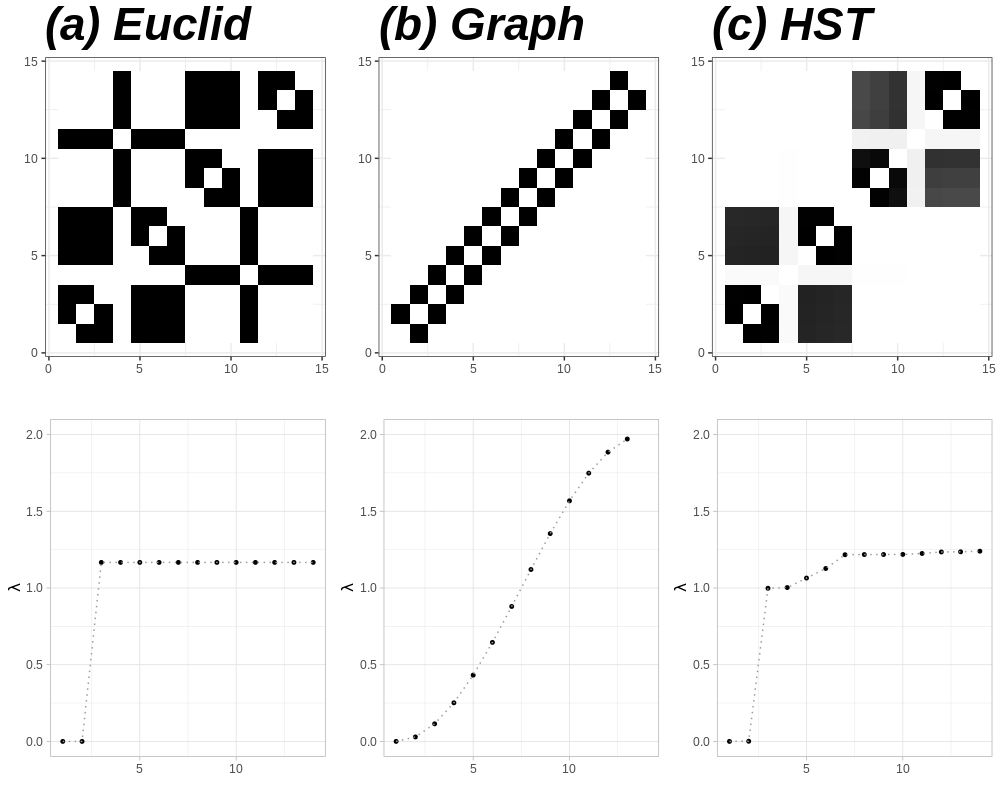

In [258]:
%%R -w 1000 -h 800 -r 100
library(gridExtra)

fig1_1<-ggplot()+geom_tile(data=W_Euclid_long,aes(x=x,y=y,fill=W))+theme_bw()+xlab("")+ylab("")+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 20, color = "black", face = "bold.italic"))+
scale_fill_gradient2(low="white",high="black")+
labs(fill=TeX('$W$'))+
theme(legend.position="none")+theme(legend.key=element_blank())+
ggtitle("(a) Euclid")+theme(plot.title=element_text(face="bold.italic",size=rel(3)))

fig1_2<-ggplot()+geom_tile(data=W_Graph_long,aes(x=x,y=y,fill=W))+theme_bw()+xlab("")+ylab("")+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 20, color = "black", face = "bold.italic"))+
scale_fill_gradient2(low="white",high="black")+
labs(fill=TeX('$\\hat{W}$'))+
theme(legend.position="none")+theme(legend.key=element_blank())+
ggtitle("(b) Graph")+theme(plot.title=element_text(face="bold.italic",size=rel(3)))

fig1_3<-ggplot()+geom_tile(data=W_HST_long,aes(x=x,y=y,fill=W))+theme_bw()+xlab("")+ylab("")+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 20, color = "black", face = "bold.italic"))+
scale_fill_gradient2(low="white",high="black")+
labs(fill=TeX('$\\hat{W}(\\tau)$'))+
theme(legend.position="none")+theme(legend.key=element_blank())+
ggtitle("(c) HST")+theme(plot.title=element_text(face="bold.italic",size=rel(3)))

fig1_4<-eigenplot(gfftrslt_Euclid)+ylim(0,2)+theme_light()
fig1_5<-eigenplot(gfftrslt_Graph)+ylim(0,2)+theme_light()
fig1_6<-eigenplot(gfftrslt_HST)+ylim(0,2)+theme_light()
fig1=grid.arrange(fig1_1,fig1_2,fig1_3,fig1_4,fig1_5,fig1_6,ncol=3,nrow=2)
fig1
ggsave(plot=fig1,"temp.pdf",width=15,height=10)

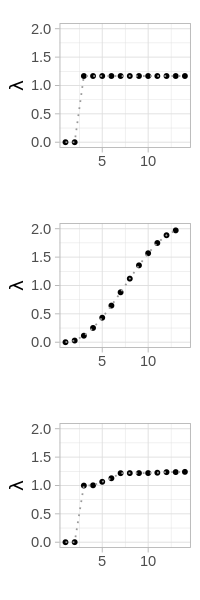

In [259]:
%%R -w 200 -h 600 -r 120
fig_= grid.arrange(fig1_4,fig1_5,fig1_6,nrow=3)
ggsave(plot=fig_,"spectrum.pdf",width=2,height=6)

### R을 활용한 시각화 (3): Decomposition 

`-` 디콤포지션을 수행하고 결과를 저장: $(\bf{f},\bf{W})$에 decomposition을 수행하고 그 결과를 각각 `decomprslt_Euclid`, `decomprslt_Graph`, `decomprslt_HST`에 저장한다. 

In [260]:
%%R 
decomprslt_Euclid<-decompose(f,W_Euclid,V=1:n) # 0, 35000, 60000, 80000
decomprslt_Graph<-decompose(f,W_Graph,V=1:n) # 0, 35000, 60000, 80000
decomprslt_HST<-decompose(f,W_HST,V=1:n) # 0, 35000, 60000, 80000

`-` 디콤포지션 결과는 아래와 같은 형태임 

In [261]:
%%R
head(decomprslt_Euclid)

# A tibble: 6 × 5
      V Vindex eigenvectorindex      fhat eigenvalue
  <int>  <int>            <dbl>     <dbl>      <dbl>
1     1      1                1  1.45e-32   3.28e-18
2     2      2                1  2.48e-17   3.28e-18
3     3      3                1 -2.02e-16   3.28e-18
4     4      4                1  1   e+ 0   3.28e-18
5     5      5                1  8.73e-17   3.28e-18
6     6      6                1 -6.32e-17   3.28e-18


In [262]:
%%R 
decomprslt_Euclid$method="Euclid"
decomprslt_Graph$method="Graph"
decomprslt_HST$method="HST"
decomprslt<-rbind(decomprslt_Euclid,decomprslt_Graph,decomprslt_HST)

`-` 디콤포지션결과를 시각화한다. `geom_col`과 `facet_grid`를 이용. 

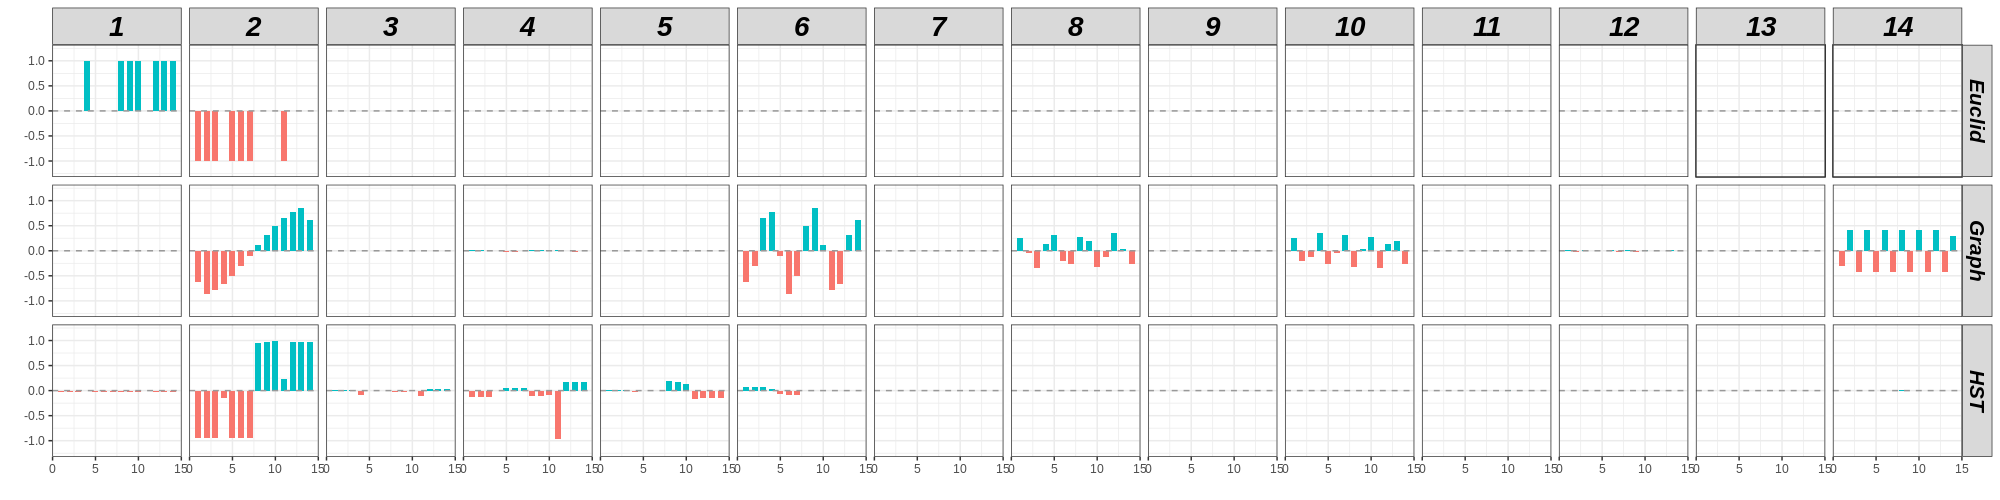

In [263]:
%%R -w 2000 -h 500 -r 100
fig2<-ggplot(data=decomprslt,aes(x=V,y=fhat))+
geom_col(aes(fill=fhat>0),width=0.7)+facet_grid(method~eigenvectorindex)+geom_hline(aes(yintercept=0),col="gray60",lty=2)+
xlab("")+ylab("")+guides(fill=FALSE)+theme(plot.title=element_text(face="bold.italic"))+theme_bw()+
theme(strip.text.x = element_text(size = 20, color = "black", face = "bold.italic"))+
theme(strip.text.y = element_text(size = 15, color = "black", face = "bold.italic"))+
ylim(-1.2,1.2)+
theme(plot.title=element_text(face="bold.italic"))
fig2
#ggsave(plot=fig2,"./fig/2021-0514_fig2.pdf",width=20,height=6)

### Appendix 

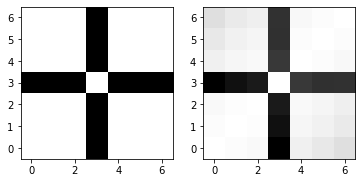

In [19]:
_, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(hst.eucliddistance[:7,:7],origin='lower')
ax2.imshow(hst.snowdistance[:7,:7],origin='lower')
plt.show()

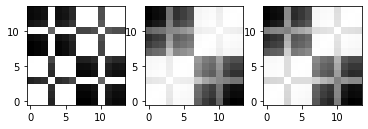

In [20]:
brk=500
_, (ax1,ax2,ax3) = plt.subplots(1,3) 
ax1.imshow(l2distance(hst.snowygrounds[:,0:brk]),origin='lower')
ax2.imshow(l2distance(hst.snowygrounds[:,brk:]),origin='lower')
ax3.imshow(hst.snowdistance,origin='lower')
#ax4.imshow(diffusion_distance)
plt.show()

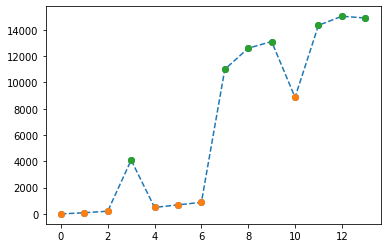

In [21]:
y=hst.snowdistance[0]
plt.plot(y,'o--')
plt.plot([0,1,2,4,5,6,10],y[[0,1,2,4,5,6,10]],'o')
plt.plot([3,7,8,9,11,12,13],y[[3,7,8,9,11,12,13]],'o')

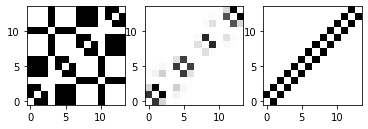

In [22]:
p, (ax1,ax2,ax3) = plt.subplots(1,3) 
ax1.imshow(hst.euclidweight,origin='lower')
ax2.imshow(hst.snowweight,origin='lower')
ax3.imshow(hst.graphweight,origin='lower')
#ax4.imshow(diffusion_distance)
#p.show()
p.savefig('temp.pdf', transparent=True)